In [1]:
!pip install evaluate --q
!pip install datasets --q
!pip install markovify --q
!pip install pymorphy2 --q
!pip install huggingface_hub --q
!pip install transformers==4.28.0 --q

In [48]:
!pip install wandb --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [1]:
import os
import re
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List
from functools import lru_cache, partial

import nltk
import torch
import wandb
import evaluate
import markovify
import pymorphy2
import matplotlib.pyplot as plt
from scipy.special import softmax
from nltk.corpus import stopwords
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
from transformers.trainer_utils import set_seed
from transformers import BertForSequenceClassification, BertTokenizerFast, \
    TrainingArguments, Trainer, EvalPrediction, DataCollatorWithPadding, RobertaTokenizerFast

In [2]:
import transformers


transformers.__version__

'4.28.0'

### Пользовательские функции

In [3]:
# Директория для обозначения настроек и интеграции с Kaggle
# Распаковка в Ubuntu осуществляется с помощью !unzip, для Windows - ручная разархивация
# os.environ['KAGGLE_CONFIG_DIR'] = 'C:\\Users\\Пользователь\\Documents\\Учеба\\Диплом\\Практика'
# Отключение уведомлений от transformers
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

---
Блок для Google Colab

In [5]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irinachalova","key":"410ecbba983016618177cefec768582e"}'}

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d egorovm/patient-disease

patient-disease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip patient-disease.zip

Archive:  patient-disease.zip
replace diagnozes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace disease_clean_symptoms.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

---

In [4]:
# MorphAnalyzer выполняет морфологический анализ русских слов. Он предоставляет возможность получать различные 
# морфологические свойства слова, такие как нормальная форма (лемма), грамматические признаки, часть речи и другие.
morph = pymorphy2.MorphAnalyzer()

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
SEED = 42
set_seed(SEED)

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Создание директории с результатом работы модели
def create_result_directory(result_path='/content/result'):
    result_path = '/content/result'
    logging_path = result_path + '/logging'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
        os.makedirs(logging_path)
        print('Директории успешно созданы.')
    else:
        print('Произошла ошибка при создании директорий.')

In [9]:
# Чистка текста от лишних символов
def clean_text(text: str) -> str:
    # Удаление тегов HTML
    text = re.sub(r'<[^>]*>', '', text)
    # Удаление тегов в начале абзаца
    text = re.sub(r'[\n\t\br\b]', '', text)
    # Добавление пробелов после символов
    text = re.sub(r'([,.:?])([^\s])', r'\1 \2', text)
    # Разделение предложения, если в слове содержится одна заглавная буква
    text = re.sub(r'(?<=[a-zа-яё])\s*(?=[A-ZА-ЯЁ])', '. ', text)
    text = re.sub(r'(?<=\S)-(?=\s|$)', ' -', text)
    # Добавление пространства между числом и значением (15мм в 15 мм)
    text = re.sub(r'(?<=\d)(?=\D)|(?<=\D)(?=\d)', ' ', text)
    # Удаление двух пробелов
    text = re.sub(r'\s+', ' ', text)
    # Удаление пробела в конце
    text = text.rstrip()
    return text


# Удаление записей о прикрепленных файлах
def truncate_string(text: str) -> str:
    keyword = 'Прикрепленные файлы'
    if keyword in text:
        sentences = text.split('.')
        for i, s in enumerate(sentences):
            if keyword in s:
                return '.'.join(sentences[:i])
    return text


# Приведение слов к нормальной форме
@lru_cache(maxsize=None) 
def norm_form_cached(word: str):
    return morph.parse(word)[0].normal_form


# Очищает текст от стоп-слов в русском языке
def stop_words_detection(text: str) -> str:
    russian_stopwords = RUSSIAN_STOPWORDS
    text_tokens = nltk.word_tokenize(text)
    cleaned_text = ' '.join(token.strip() for token in text_tokens
                            if token not in russian_stopwords)
    return cleaned_text


# Обработка текстов обращений
tqdm.pandas()
def preprocess_case(patient_case: pd.DataFrame) -> pd.Series:
    patient_case.case = (
        patient_case.case
        .progress_apply(lambda text: clean_text(text))
        .apply(lambda text: truncate_string(text))
        .progress_apply(lambda text: stop_words_detection(text))
        .progress_apply(lambda text: ' '.join([norm_form_cached(word) for word in text.split()]))
    ) 
    return patient_case.case

In [10]:
# Токенизация
def process_data(example: Dataset, tokenizer, max_length: int) -> Dataset:
    result = tokenizer(
                        example['case'],
                        truncation=True,
                        return_token_type_ids=True,
                        max_length=max_length,
                        padding=True,
                        return_tensors='pt'
                      )
    result['labels'] = example['name']
    return result

In [11]:
# Генерация фейковых данных
def oversampling_data(df: pd.DataFrame, text_column: str, class_column: List, 
                      target_classes: List, 
                      num_samples: int, min_text_length=3) -> pd.DataFrame:
    generated_data = []

    for target_class in target_classes:
        df_class = df[df[class_column] == target_class]
        df_filtered = df_class[df_class[text_column].str.len() >= min_text_length]

        # Объединяем все тексты в одну строку для обучения модели
        combined_text = ' '.join(df_filtered[text_column].tolist())

        # Создаем модель на основе цепей Маркова
        text_model = markovify.Text(combined_text, state_size=2)
        generated_samples = [text_model.make_sentence() for _ in range(num_samples)]
        df_generated = pd.DataFrame({text_column: generated_samples,
                                     class_column: target_class})
        generated_data.append(df_generated)

    df_combined = pd.concat([df] + generated_data)
    return df_combined

# Урезание данных
def undersampling_data(df: pd.DataFrame, sample=200) -> pd.DataFrame:
    class_counts = df['name'].value_counts()
    df_undersampled = pd.DataFrame()

    for class_label, count in class_counts.items():
        df_class = df[df['name'] == class_label]
        if count > 200:
            df_class = df_class.sample(n=sample, random_state=SEED)
        df_undersampled = pd.concat([df_undersampled, df_class])
    return df_undersampled


# Функция для устранения дисбаланса классов
def sampling(df: pd.DataFrame, num_labels: int):
    classes_to_oversample = df['name'].value_counts().nsmallest(num_labels//2).index.tolist()
    classes_to_undersample = df['name'].value_counts().nlargest(num_labels//2).index.tolist()

    # Разделение DataFrame на две части в соответствии с выбранными классами
    df_oversample = df[df['name'].isin(classes_to_oversample)]
    df_undersample = df[df['name'].isin(classes_to_undersample)]

    target_classes = df_oversample.name.unique().tolist()
    code_classes = df_oversample.name.unique().tolist()

    df_oversample = oversampling_data(df=df_oversample, text_column='case', 
                                      class_column='name',
                                      target_classes=target_classes, 
                                      num_samples=200)
    
    df_undersample = undersampling_data(df=df_undersample, sample=200)
    return df_oversample, df_undersample

In [12]:
# Получение предсказаний
def get_per_instance_preds(flattened_preds):
    true_probs = softmax(flattened_preds, axis=1)
    return np.argmax(true_probs, axis=1)

# Расчет метрики
def compute_metrics(p: EvalPrediction, **kwargs):
    preds = p.predictions
    per_instance_preds = get_per_instance_preds(preds)
    label_ids = p.label_ids #.reshape((per_instance_preds.shape[0], 2)).argmax(axis=1)  # [0, 1] -> 1, [1, 0] -> 0

    # f1_macro = F1.compute(predictions=per_instance_preds, references=label_ids, average='macro')
    f1_weighted = F1.compute(predictions=per_instance_preds, references=label_ids, average='weighted')
    result = {'eval_f1': f1_weighted['f1']}
    return result

In [13]:
# Обработка полученных предсказаний
def process_predictions(p: np.ndarray, label_encoder, **kwargs):
    true_probs = softmax(p, axis=1)
    preds_list = np.argmax(true_probs, axis=1).tolist()
    preds_list = label_encoder.inverse_transform(preds_list).tolist()
    preds_list = [{'idx': idx, 'name': prediction}
                  for idx, prediction in enumerate(preds_list)]
    return preds_list

### Загрузка данных

In [18]:
# !kaggle datasets download -d egorovm/patient-disease
# !unzip patient-disease.zip

### Предобработка данных

In [14]:
# Путь в Windows
# DATA_PATH = r'C:\Users\Пользователь\Documents\Учеба\Диплом\Практика\BERT_classification\data\patient_case.csv' 
# Путь в Colab
DATA_PATH = '/content/patient_case.csv'

In [15]:
dataset = pd.read_csv(DATA_PATH)
dataset.iloc[743]

id                       36466e53a1a344b182569b638e9b3a21
name                                    Гастроэнтерология
case    <div class="postcolor" id="post-21951">\n\t\t\...
url     https://meduniver.com/forum/index.php?s=63007a...
Name: 743, dtype: object

In [66]:
dataset.duplicated().any()

False

In [22]:
dataset.isna().any()

id      False
name    False
case     True
url     False
dtype: bool

In [16]:
dataset = dataset.loc[dataset.case.notna()]
dataset.isna().any()

id      False
name    False
case    False
url     False
dtype: bool

In [68]:
dataset.nunique()

id      5193
name      25
case    5164
url     5164
dtype: int64

In [69]:
dataset.shape

(5193, 4)

<Axes: >

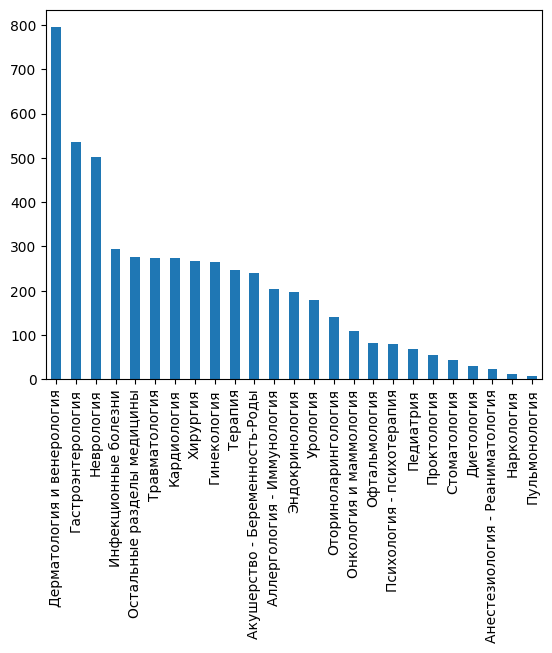

In [70]:
dataset.name.value_counts().plot(kind='bar')

В данных есть дубликаты, обусловленные двойной классификацией на обращение. В целом, эти данные можно удалить или присвоить им только один из имеющихся классов. Выберем второй вариант, поскольку данных не очень много.

In [17]:
urls = dataset.loc[dataset['url'].duplicated(), 'url']
condition = dataset['name'] != 'Остальные разделы медицины'
filtered_dataset = dataset[~dataset['url'].isin(urls) | condition]

filtered_dataset.shape

(5165, 4)

In [72]:
filtered_dataset.nunique()

id      5165
name      25
case    5164
url     5164
dtype: int64

In [18]:
filtered_dataset.drop(['id', 'url'], axis=1, inplace=True)

<ipython-input-18-87bb6017e5fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset.drop(['id', 'url'], axis=1, inplace=True)


In [30]:
filtered_dataset.head(3)

,name,case
0,Акушерство - Беременность-Роды,"<div class=""postcolor"" id=""post-40777"">\n\t\t\..."
1,Акушерство - Беременность-Роды,"<div class=""postcolor"" id=""post-40637"">\n\t\t\..."
2,Акушерство - Беременность-Роды,"<div class=""postcolor"" id=""post-40361"">\n\t\t\..."


In [19]:
# Количество меток
num_labels = filtered_dataset.name.nunique()
# Борьба с дисбалансом классов
df_oversample, df_undersample = sampling(filtered_dataset, num_labels)

In [20]:
df_oversample.dropna(inplace=True)
df_oversample.drop_duplicates(inplace=True)
df_oversample.name.value_counts()

Урология                           287
Оториноларингология                238
Психология - психотерапия          195
Онкология и маммология             161
Офтальмология                      112
Педиатрия                           98
Проктология                         92
Стоматология                        56
Диетология                          49
Анестезиология - Реаниматология     29
Наркология                          12
Пульмонология                        8
Name: name, dtype: int64

In [21]:
df_undersample.name.value_counts()

Дерматология и венерология        200
Гастроэнтерология                 200
Неврология                        200
Инфекционные болезни              200
Травматология                     200
Кардиология                       200
Хирургия                          200
Гинекология                       200
Остальные разделы медицины        200
Терапия                           200
Акушерство - Беременность-Роды    200
Аллергология - Иммунология        200
Name: name, dtype: int64

In [22]:
part_df = df_oversample.loc[df_oversample.name.isin([
    'Анестезиология - Реаниматология',
    'Наркология', 'Пульмонология',
    'Диетология', 'Стоматология', 'Проктология'])]

df_oversample = df_oversample.query("name not in ['Анестезиология - Реаниматология', 'Наркология', 'Пульмонология', 'Диетология', 'Стоматология', 'Проктология']")

part_df.name = 'Остальные разделы медицины'
part_df.head(3)

<ipython-input-22-dee13439373d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df.name = 'Остальные разделы медицины'


,name,case
443,Остальные разделы медицины,"<div class=""postcolor"" id=""post-36289"">\n\t\t\..."
444,Остальные разделы медицины,"<div class=""postcolor"" id=""post-34886"">\n\t\t\..."
445,Остальные разделы медицины,"<div class=""postcolor"" id=""post-25472"">\n\t\t\..."


In [77]:
df_oversample.name.value_counts()

Урология                     287
Оториноларингология          238
Психология - психотерапия    195
Онкология и маммология       161
Офтальмология                112
Педиатрия                     98
Name: name, dtype: int64

In [23]:
combined = pd.concat([df_oversample, df_undersample, part_df])
combined.name.value_counts()

Остальные разделы медицины        446
Урология                          287
Оториноларингология               238
Травматология                     200
Акушерство - Беременность-Роды    200
Терапия                           200
Гинекология                       200
Хирургия                          200
Кардиология                       200
Инфекционные болезни              200
Неврология                        200
Гастроэнтерология                 200
Дерматология и венерология        200
Аллергология - Иммунология        200
Психология - психотерапия         195
Онкология и маммология            161
Офтальмология                     112
Педиатрия                          98
Name: name, dtype: int64

In [24]:
dataset = combined.copy()
dataset.case = preprocess_case(combined)
dataset.case.head(6)

100%|██████████| 3737/3737 [00:13<00:00, 277.98it/s]


3172    подсказать пожалуйста , немного першить горло ...
3173    здравствуйте ! 2 неделя назад насморк начаться...
3174    здравствуйте , приём лор непонятный анализ . п...
3175    добрый день ! очень нужный консультация повод ...
3176    здравствуйте ! быть приём у. лор ребенок ( 13 ...
3177    добрый день . берухо мягкий , многоразовый , п...
Name: case, dtype: object

In [25]:
label_encoder = LabelEncoder()
dataset['name'] = label_encoder.fit_transform(combined['name'])

In [26]:
# Сборщик мусора, очистка памяти
gc.collect()

1237

Мы видим явный дисбаланс классов, следовательно, уже на данном этапе можно сказать, что модель не сможет достоверно определять принадлежность к малочисленными классами.

<Axes: >

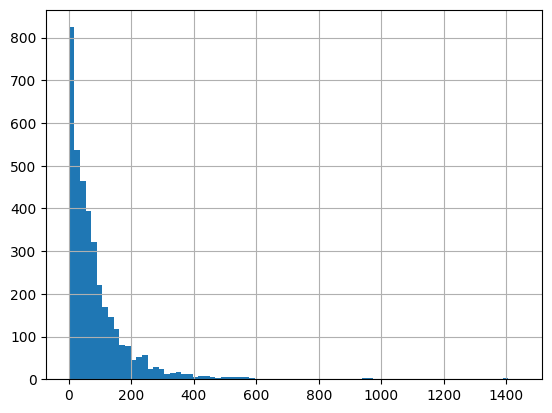

In [27]:
# Получаем длины обращений в нашем наборе данных
seq_len = [len(i.split()) for i in dataset.case]
pd.Series(seq_len).hist(bins = 80)

Ограничимся 250 символами для анализа.

### Деление выборки на train, valid, test

In [28]:
datadict = Dataset.from_pandas(dataset)

# 70% обучающая выборка, 30% - валидация и тест
train_testvalid = datadict.train_test_split(train_size=0.7, test_size=0.3)
# Делим 30% валидации и теста пополам
test_valid = train_testvalid['test'].train_test_split(train_size=0.5, test_size=0.5)

datadict = DatasetDict({'train': train_testvalid['train'],
                       'test': test_valid['test'],
                       'valid': test_valid['train']})

In [29]:
datadict['test'][4]

{'name': 0,
 'case': 'добрый день . хотеть узнать . ваш мнение . стоить диагноз сактосальпингс эндометриоз . после операция планироваться . эко . нужно операция принимать какой-то препарат ? сразу подавать документ квота ?',
 '__index_level_0__': 40}

### Импорт модели и токенизатора RuBERT с HuggingFace

In [30]:
MODEL_NAME = 'ai-forever/ruBert-base'
MAX_LENGTH = 250
NUM_LABELS = combined.name.nunique()

In [31]:
# Путь в Windows, создается вручную
# RESULT_PATH = r'C:\Users\Пользователь\Documents\Учеба\Диплом\Практика\BERT_classification\result'
# LOGGING_PATH = r'C:\Users\Пользователь\Documents\Учеба\Диплом\Практика\BERT_classification\result\logging'
# Путь в Colab
create_result_directory()
RESULT_PATH = '/content/result'
LOGGING_PATH = '/content/result/logging'

DROPOUT = 0.1
N_EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.04
METRIC = 'f1'
F1 = evaluate.load('f1')
OPTIMIZER_NAME = 'adamw_torch'

Произошла ошибка при создании директорий.


In [32]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                      num_labels=NUM_LABELS, 
                                                      attention_probs_dropout_prob=DROPOUT,
                                                      hidden_dropout_prob=DROPOUT)
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME) # RuBERT
# tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME) # RuRoBERTa

Some weights of the model checkpoint at ai-forever/ruBert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not ini

In [33]:
model = model.to(device)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

### Токенизация

In [34]:
tokenized_datadict = datadict.map(lambda example: process_data(example, tokenizer, MAX_LENGTH),
                                 batched=True)
tokenized_datadict

Map:   0%|          | 0/2615 [00:00<?, ? examples/s]

Map:   0%|          | 0/561 [00:00<?, ? examples/s]

Map:   0%|          | 0/561 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['name', 'case', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2615
    })
    test: Dataset({
        features: ['name', 'case', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 561
    })
    valid: Dataset({
        features: ['name', 'case', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 561
    })
})

In [35]:
test = tokenized_datadict['test']
tokenized_datadict = tokenized_datadict.remove_columns(['name', 'case',
                                                        '__index_level_0__'])

### Обучение

In [36]:
run = wandb.init(project='rubert-base', name=RESULT_PATH)
run.config.update({'task': 'medicine', 'model': MODEL_NAME, 'checkpoint': LOGGING_PATH})

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [37]:
training_args = TrainingArguments(
    output_dir=RESULT_PATH,
    overwrite_output_dir=True,
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    logging_first_step=True,
    logging_dir=LOGGING_PATH,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    num_train_epochs=N_EPOCHS,
    optim=OPTIMIZER_NAME,
    warmup_ratio=0.1,
    save_strategy='epoch',
    seed=SEED,
    fp16=True,
    dataloader_num_workers=2,
    group_by_length=True,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC
    )

In [38]:
data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datadict['train'],
    eval_dataset=tokenized_datadict['valid'],
    compute_metrics=partial(compute_metrics,
                            processed_dataset=tokenized_datadict['valid']),
    tokenizer=tokenizer,
    data_collator=data_collator
    )

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,2.870500,2.818871,0.041045
2,2.815800,2.758514,0.053243
3,2.713500,2.640268,0.120413
4,2.475200,2.343865,0.293392
5,2.162600,2.083321,0.401647
6,1.872000,1.893118,0.472211
7,1.659100,1.793007,0.478676
8,1.480100,1.703475,0.490296
9,1.332300,1.644317,0.503117


In [ ]:
predictions = trainer.predict(test_dataset=tokenized_datadict['test'])
print('dev', predictions.metrics)

In [ ]:
run.summary.update(predictions.metrics)
wandb.finish()

### Тестирование

In [ ]:
processed_predictions = process_predictions(predictions.predictions, label_encoder)
processed_predictions[:3]

In [ ]:
for i in range(30, 40):
    print(test['case'][i][:150] + '\t--- ' + processed_predictions[i]['name'])

### Выкладывание модели на Hugging Face

In [ ]:
MY_MODEL_PATH = RESULT_PATH + '/model'
if not os.path.exists(MY_MODEL_PATH):
    os.makedirs(MY_MODEL_PATH)

In [ ]:
trainer.save_model(MY_MODEL_PATH)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
my_model = BertForSequenceClassification.from_pretrained(MY_MODEL_PATH)

In [ ]:
my_model.push_to_hub('graviada/ruBERT-medicine-classification')

In [ ]:
my_model_check = BertForSequenceClassification.from_pretrained('graviada/ruBERT-medicine-classification')
my_model_check